<a href="https://colab.research.google.com/github/sunshineluyao/Econ-211/blob/main/Simulation/Job_Searching_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Research question: When to Accept or Reject an Offer? 

References: J J McCall. Economics of Information and Job Search. The Quarterly Journal of Economics, 84(1):113–126, 1970.

### install the QuantEcon Library 

In [3]:
!pip install quantecon ###if you use anaconda, type in the command instead: !conda install -y quantecon

     |████████████████████████████████| 235kB 5.6MB/s 


In [6]:
!pip install numba 

In [11]:
import numpy as np
from numba import jit, float64, jitclass
import matplotlib.pyplot as plt
%matplotlib inline
import quantecon as qe
from quantecon.distributions import BetaBinomial

# The Model

### The Objective function

The agent is infinitely lived and aims to maximize the expected discounted sum of earnings $E\sum_{t=0}^{\infty}\beta^{t}y_t$


*   $\beta$ is the discount factor
*   $y_{t}$ is income, equal to the wage $w_{t}$ when employed, and compensation $c$ when unemployed



### The State Value Function

$s_t$ is an i.i.d. random variable called "the State", it is distributed over a set $S$ with probability $p(s)$ for $s\in S$

*   $w_t =w(s_t)$
*   **State value function**: $v^{*}(s)$ denotes the value of the objective function given state s when an agent in this situation makes an optimal decision

*   **The bellman equation**: the state value function must satisfy the following condition
$v^{*}=max[w(s)/(1-\beta),c+\beta\sum_{s'\in S}v*(s')q(s') ]$







### The optimal policy

# Simulation

## Simulate wage distributions

In [12]:
n, a, b = 50, 200, 100                        # default parameters
q_default = BetaBinomial(n, a, b).pdf()       # default choice of q

In [13]:
w_min, w_max = 10, 60
w_default = np.linspace(w_min, w_max, n+1)

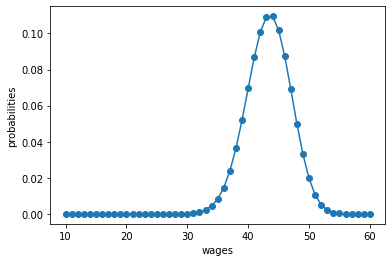

In [14]:
fig, ax = plt.subplots()
ax.plot(w_default, q_default, '-o', label='$q(w(i))$')
ax.set_xlabel('wages')
ax.set_ylabel('probabilities')

plt.show()

## Solve for the optimal policy and compute reservation wage

references:  compiling python code with @jit https://numba.pydata.org/numba-doc/latest/user/jit.html

In [15]:
mccall_data = [
    ('c', float64),      # unemployment compensation
    ('β', float64),      # discount factor
    ('w', float64[:]),   # array of wage values, w[i] = wage at state i
    ('q', float64[:])    # array of probabilities
]

In [16]:
@jitclass(mccall_data)
class McCallModel:

    def __init__(self, c=25, β=0.99, w=w_default, q=q_default):

        self.c, self.β = c, β
        self.w, self.q = w_default, q_default

    def state_action_values(self, i, v):
        """
        The values of state-action pairs.
        """
        # Simplify names
        c, β, w, q = self.c, self.β, self.w, self.q
        # Evaluate value for each state-action pair
        # Consider action = accept or reject the current offer
        accept = w[i] / (1 - β)
        reject = c + β * np.sum(v * q)

        return np.array([accept, reject])

In [17]:
def plot_value_function_seq(mcm, ax, num_plots=6):
    """
    Plot a sequence of value functions.

        * mcm is an instance of McCallModel
        * ax is an axes object that implements a plot method.

    """

    n = len(mcm.w)
    v = mcm.w / (1 - mcm.β)
    v_next = np.empty_like(v)
    for i in range(num_plots):
        ax.plot(mcm.w, v, '-', alpha=0.4, label=f"iterate {i}")
        # Update guess
        for i in range(n):
            v_next[i] = np.max(mcm.state_action_values(i, v))
        v[:] = v_next  # copy contents into v

    ax.legend(loc='lower right')

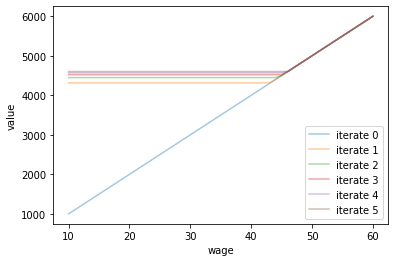

In [18]:
mcm = McCallModel()

fig, ax = plt.subplots()
ax.set_xlabel('wage')
ax.set_ylabel('value')
plot_value_function_seq(mcm, ax)
plt.show()

In [19]:
@jit(nopython=True)
def compute_reservation_wage(mcm,
                             max_iter=500,
                             tol=1e-6):

    # Simplify names
    c, β, w, q = mcm.c, mcm.β, mcm.w, mcm.q

    # == First compute the value function == #

    n = len(w)
    v = w / (1 - β)          # initial guess
    v_next = np.empty_like(v)
    i = 0
    error = tol + 1
    while i < max_iter and error > tol:

        for i in range(n):
            v_next[i] = np.max(mcm.state_action_values(i, v))

        error = np.max(np.abs(v_next - v))
        i += 1

        v[:] = v_next  # copy contents into v

    # == Now compute the reservation wage == #

    return (1 - β) * (c + β * np.sum(v * q))

In [20]:
compute_reservation_wage(mcm)

47.316499710024964

## Comparative Statics 

### the resevation wage

In [21]:
grid_size = 25
R = np.empty((grid_size, grid_size))

c_vals = np.linspace(10.0, 30.0, grid_size)
β_vals = np.linspace(0.9, 0.99, grid_size)

for i, c in enumerate(c_vals):
    for j, β in enumerate(β_vals):
        mcm = McCallModel(c=c, β=β)
        R[i, j] = compute_reservation_wage(mcm)

contour plot : 

https://problemsolvingwithpython.com/06-Plotting-with-Matplotlib/06.14-Contour-Plots/

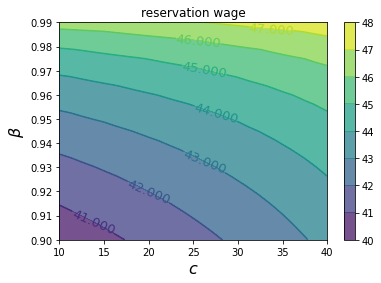

In [27]:
fig, ax = plt.subplots()

cs1 = ax.contourf(c_vals, β_vals, R.T, alpha=0.75)
ctr1 = ax.contour(c_vals, β_vals, R.T)

plt.clabel(ctr1, inline=1, fontsize=13)
plt.colorbar(cs1, ax=ax)


ax.set_title("reservation wage")
ax.set_xlabel("$c$", fontsize=16)
ax.set_ylabel("$β$", fontsize=16)

ax.ticklabel_format(useOffset=False)

plt.show()

In [29]:
line_lens =30
c=10
β_vals = np.linspace(0.9, 0.99, line_lens)
R = np.empty((line_lens,1))
for j, β in enumerate(β_vals):
        mcm = McCallModel(c=c, β=β)
        R[j] = compute_reservation_wage(mcm)

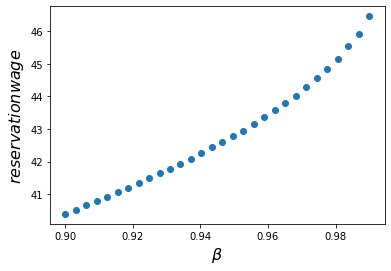

In [31]:
fig, ax = plt.subplots()

cs2 = ax.scatter(β_vals, R)


ax.set_xlabel("$β$", fontsize=16)
ax.set_ylabel("$reservation wage$", fontsize=16)

ax.ticklabel_format(useOffset=False)

plt.show()

In [41]:
line_lens =30
β=0.5
c_vals = np.linspace(10, 40, line_lens)
R = np.empty((line_lens,1))
for i, c in enumerate(c_vals):
        mcm = McCallModel(c=c, β=β)
        R[j] = compute_reservation_wage(mcm)

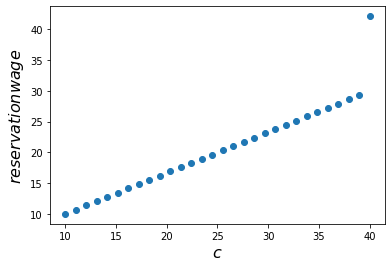

In [42]:
fig, ax = plt.subplots()

cs3 = ax.scatter(c_vals, R)


ax.set_xlabel("$c$", fontsize=16)
ax.set_ylabel("$reservation wage$", fontsize=16)

ax.ticklabel_format(useOffset=False)

plt.show()

### the duration of unemploymnet 

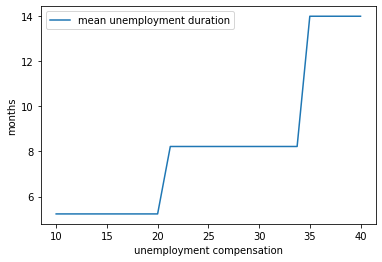

In [24]:
cdf = np.cumsum(q_default)

@jit(nopython=True)
def compute_stopping_time(w_bar, seed=1234):

    np.random.seed(seed)
    t = 1
    while True:
        # Generate a wage draw
        w = w_default[qe.random.draw(cdf)]
        # Stop when the draw is above the reservation wage
        if w >= w_bar:
            stopping_time = t
            break
        else:
            t += 1
    return stopping_time

@jit(nopython=True)
def compute_mean_stopping_time(w_bar, num_reps=100000):
    obs = np.empty(num_reps)
    for i in range(num_reps):
        obs[i] = compute_stopping_time(w_bar, seed=i)
    return obs.mean()

c_vals = np.linspace(10, 40, 25)
stop_times = np.empty_like(c_vals)
for i, c in enumerate(c_vals):
    mcm = McCallModel(c=c)
    w_bar = compute_reservation_wage(mcm)
    stop_times[i] = compute_mean_stopping_time(w_bar)

fig, ax = plt.subplots()

ax.plot(c_vals, stop_times, label="mean unemployment duration")
ax.set(xlabel="unemployment compensation", ylabel="months")
ax.legend()

plt.show()